## GCM Capstone - Intrudoce the missing data


**March 26, 2024**

In [1]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pl.read_csv('hall18_cgm_plus_features.csv') # replace with the complete data file path

In [3]:
df = df.select(pl.col('SID', 'Day', 'Hour', 'Min', 'DT_Index', 'DailyTI_Index', 'StudyTI_Index', 'Value'))

In [4]:
df = df.with_columns(
    pl.when(pl.col("StudyTI_Index").diff() < 0)
    .then(0)
    .otherwise(pl.col("StudyTI_Index").diff())
    .alias("diff")
)
df = df.with_columns((pl.col("diff") - 1).fill_null(pl.lit(0)).alias("missing_counts"))

In [6]:
df= df.to_pandas()

In [8]:
daily_counts = df.groupby(['SID', 'Day'])['missing_counts'].sum().reset_index(name='total_missing')
daily_counts1 = daily_counts[daily_counts['total_missing'] > 0]
daily_counts1

,SID,Day,total_missing
1,HALL18-1636-69-001,1,1
3,HALL18-1636-69-001,419,120066
4,HALL18-1636-69-001,420,2
5,HALL18-1636-69-001,421,44
6,HALL18-1636-69-001,422,1
...,...,...,...
465,HALL18-2133-041,1,2
466,HALL18-2133-041,2,178
469,HALL18-2133-041,5,39
470,HALL18-2133-041,6,3


In [7]:
daily_counts = df.groupby(['SID', 'Day']).size().reset_index(name='count')
daily_counts


,SID,Day,count
0,HALL18-1636-69-001,0,244
1,HALL18-1636-69-001,1,287
2,HALL18-1636-69-001,2,223
3,HALL18-1636-69-001,419,95
4,HALL18-1636-69-001,420,252
...,...,...,...
468,HALL18-2133-041,4,288
469,HALL18-2133-041,5,249
470,HALL18-2133-041,6,285
471,HALL18-2133-041,7,115


In [8]:
full_days = daily_counts[daily_counts['count'] == 288]
complete_data_all = pd.merge(df, full_days[['SID', 'Day']], on=['SID', 'Day'], how='inner')
complete_data_all

,SID,Day,Hour,Min,DT_Index,DailyTI_Index,StudyTI_Index,Value,diff,missing_counts
0,HALL18-1636-69-032,1,0,3,2016-01-14 00:00:00,0,288,120.0,1.0,0
1,HALL18-1636-69-032,1,0,8,2016-01-14 00:05:00,1,289,120.0,1.0,0
2,HALL18-1636-69-032,1,0,13,2016-01-14 00:10:00,2,290,123.0,1.0,0
3,HALL18-1636-69-032,1,0,18,2016-01-14 00:15:00,3,291,126.0,1.0,0
4,HALL18-1636-69-032,1,0,23,2016-01-14 00:20:00,4,292,127.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
16987,HALL18-2133-041,4,23,36,2017-07-07 23:35:00,283,1435,124.0,1.0,0
16988,HALL18-2133-041,4,23,41,2017-07-07 23:40:00,284,1436,125.0,1.0,0
16989,HALL18-2133-041,4,23,46,2017-07-07 23:45:00,285,1437,127.0,1.0,0
16990,HALL18-2133-041,4,23,51,2017-07-07 23:50:00,286,1438,129.0,1.0,0


In [9]:
def plot_complete_reading(df, i):
    start_index = i * 288
    end_index = (i + 1) * 288
    
    cycle_data = df.iloc[start_index:end_index]
    sid = cycle_data['SID'].iloc[0]
    day = cycle_data['Day'].iloc[0]

    #plt.figure(figsize=(20, 18))
    plt.plot(cycle_data['DailyTI_Index'], cycle_data['Value'], marker='o', linestyle='-', color='r', markersize=3)
    plt.title(f'Complete Reading for {sid}, Day {day} Values over Time')
    plt.xlabel('Time')
    plt.ylabel('Value')
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



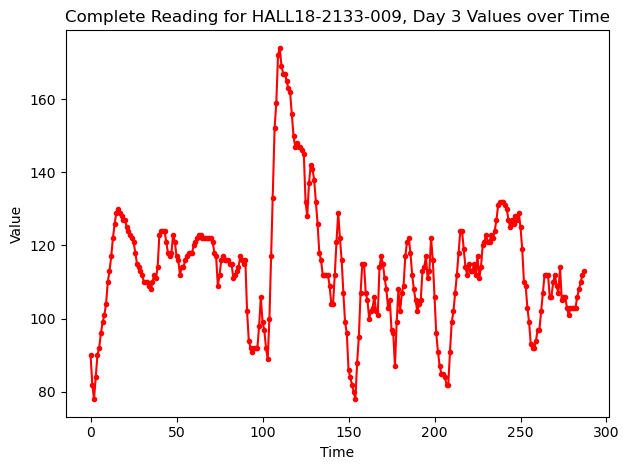

In [10]:

plot_complete_reading(complete_data_all, 28)


In [11]:
daily_counts = df.groupby(['SID', 'Day']).size().reset_index(name='count')
incomplete_days = daily_counts[daily_counts['count'] != 288]


In [13]:
df1= df[(df['SID'] == 'HALL18-2133-041') & (df['Day'] == 5)]
df1= df1[['DailyTI_Index', 'Value']]
df2= pd.DataFrame({'DailyTI_Index': range(0, 288)})
df3 = pd.merge(df2, df1, on='DailyTI_Index', how='left')

,DailyTI_Index,Value
0,0,131.0
1,1,131.0
2,2,131.0
3,3,129.0
4,4,127.0
...,...,...
283,283,141.0
284,284,145.0
285,285,148.0
286,286,150.0


In [25]:
def plot_incomplete_data(df):
    mask = df['Value'].isna() 
    plt.plot(df['DailyTI_Index'], df['Value'], marker='o', linestyle='-', markersize=2, label='Data Points', color='r')

    plt.plot(df['DailyTI_Index'][mask], [75] * sum(mask), 'x', markersize=2, label='Missing Data Points')
    plt.title('Incomplete Reading for HALL18-2133-041, Day 5 Values over Time')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

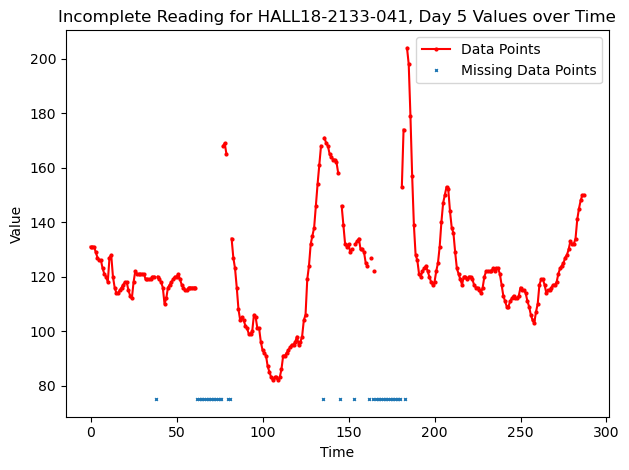

In [26]:

plot_incomplete_data(df3)  